In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .getOrCreate()

# Define file names
file_names = ["03_May_84_recession.csv", 
              "04_May_128_recession.csv",
              "05_May_150_recession.csv",
              "06_May_141_recession.csv",
              "07_May_172_recession.csv",
              "08_May_24_reccession.csv",
              "09_May_19_reccession.csv",
              "10_May_40_reccession.csv",
              "11_May_09_reccession.csv",
              "12_May_33_reccession.csv",
              "13_May_34_reccession.csv",
              "26_Apr_333_reccession.csv"
              ]

# Combine data
df = None
for file_name in file_names:
    df_temp = spark.read.csv(f"/content/drive/MyDrive/data-pdb/{file_name}", inferSchema=True, header=True)
    if df is None:
        df = df_temp
    else:
        df = df.union(df_temp)

## Data Understanding

### Collecting Data

In [4]:
df.show()

+--------------------+--------------------+
|                Date|               Tweet|
+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...|
|2023-05-03 06:25:...|"@saxena_puru But...|
|2023-05-03 06:25:...|@_swimfish @stats...|
|India🇮🇳 has rep...|                null|
|2023-05-03 06:24:...|@TaxpayersParty @...|
|2023-05-03 06:24:...|After losing at H...|
|Recession probabi...|               2023:|
|           India- 0%|                null|
|       Pakistan- 40%|                null|
|     Bangladesg- 33%|                null|
|Big blow to Modi'...|                null|
|2023-05-03 06:24:...|@TheKouk You have...|
|2023-05-03 06:24:...|Republicans' posi...|
|- They ARE willin...| kills millions o...|
|- They are NOT wi...|                null|
|2023-05-03 06:23:...|The Treasury Dept...|
|MAGA Republicans ...|                null|
|     Their demands? |                null|
|Either let them d...|000 jobs &amp; ca...|
|2023-05-03 06:23:...|@CWeston_Ind

### Describe Data

In [5]:
df.describe().show()

+-------+--------------------+--------------------+
|summary|                Date|               Tweet|
+-------+--------------------+--------------------+
|  count|                2095|                1261|
|   mean|                null|                null|
| stddev|                null|                null|
|    min|    God will help...| #banking tension...|
|    max|🧊 US job market ...|🤡 First 'transit...|
+-------+--------------------+--------------------+



In [6]:
df.columns

['Date', 'Tweet']

In [7]:
# Counting Row and Columns Exist in DF

print(f"Terdapat sebanyak {df.count()} baris dan sebanyak {len(df.columns)} kolom pada dataset.")

Terdapat sebanyak 2095 baris dan sebanyak 2 kolom pada dataset.


In [8]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Tweet: string (nullable = true)



In [9]:
df.dtypes

[('Date', 'string'), ('Tweet', 'string')]

### Validation Data

In [10]:
# check null values pada dataset
from pyspark.sql.functions import count

def _count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

_count(df)

+----+-----+
|Date|Tweet|
+----+-----+
|2095| 1261|
+----+-----+



In [11]:
# Menghitung jumlah nilai null pada dataframe secara keseluruhan
df.filter(df["Date"].isNull() | df["Tweet"].isNull()).count()

834

## Data Preparation

### Data Cleaning

In [12]:
# Drop any rows with null values first
df = df.na.drop(subset=["Tweet"])

In [13]:
# Counting Row and Columns Exist in DF

print(f"Terdapat sebanyak {df.count()} baris dan sebanyak {len(df.columns)} kolom pada dataset saat ini.")

Terdapat sebanyak 1261 baris dan sebanyak 2 kolom pada dataset saat ini.


## Text Preprocessing

Remove stopwords, punctuations, links, and stem the data

In [14]:
import re, string

def filtering(text):
    #remove link web
    text = re.sub(r'https*\S+', ' ', str(text))
    #remove @username
    text = re.sub(r'@[^\s]+', ' ', text)
    #remove #tagger
    text = re.sub(r'#[^\w]+', ' ', text)
    text = re.sub(r"[.,:;+!\-_<^/=?&|$\"\(\)\d\*]", " ", text)
    #remove extra spaces
    text = re.sub('  +', ' ', text) 
    #remove \n
    text = re.sub('\n+',' ',text)
    text = re.sub('\ ■',' ',text)
    text = re.sub(r'&[^\s]+', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Membuat UDF dari filtering
filtering_udf = udf(filtering, StringType())

# Mengaplikasikan UDF pada kolom "Tweet" untuk membuat kolom baru "text_clean"
df = df.withColumn("text_clean", filtering_udf(df["Tweet"]))

# Menampilkan semua kolom pada dataframe
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
df.show(1)


+--------------------+--------------------+--------------------+
|                Date|               Tweet|          text_clean|
+--------------------+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...| US is full of ne...|
+--------------------+--------------------+--------------------+
only showing top 1 row



In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'\s*\d+\s*', '', text)
    text = re.sub('/[^\w\s]/gi', '', text)
    text = re.sub("@[^0-9a-zA-Z]+", '',text)
    text = re.sub(r'@[^\s]+', ' ', text)
    text = re.sub(r'#[^\w]+', ' ', text)
    text = re.sub(r"[.,:;+!\-_<^/=?&|$\"\(\)\d\*]", " ", text)
    text = re.sub('  +', ' ', text) 
    text = re.sub('\n+',' ',text)
    text = re.sub('\ ■',' ',text)
    text = re.sub(r'&[^\s]+', ' ', text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " ", text)
    text = re.sub(r"\)", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r'\S*(x{2,}|X{2,})\S*',"xxx", text)
    text = re.sub(r'[^\x00-\x7F]+', "", text)
    text = re.sub('rt ', '', text)
    text = re.sub('|', '', text)

    return text

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Membuat UDF dari clean_text
clean_text_udf = udf(clean_text, StringType())

# Mengaplikasikan UDF pada kolom "Tweet" untuk membuat kolom baru "text_clean"
df = df.withColumn("text_clean", clean_text_udf(df["Tweet"]))
df.show(1)

+--------------------+--------------------+--------------------+
|                Date|               Tweet|          text_clean|
+--------------------+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...| us is full of ne...|
+--------------------+--------------------+--------------------+
only showing top 1 row



In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [20]:
# Membuat UDF dari remove_stopwords
remove_stopwords_udf = udf(remove_stopwords, StringType())

# Mengaplikasikan UDF pada kolom "Tweet" untuk membuat kolom baru "text_clean"
df = df.withColumn("text_clean", remove_stopwords_udf(df["text_clean"]))

In [21]:
df.show(5)

+--------------------+--------------------+--------------------+
|                Date|               Tweet|          text_clean|
+--------------------+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...| us full news deb...|
|2023-05-03 06:25:...|"@saxena_puru But...|saxenapuru know c...|
|2023-05-03 06:25:...|@_swimfish @stats...|swimfish statsfee...|
|2023-05-03 06:24:...|@TaxpayersParty @...|taxpayersparty av...|
|2023-05-03 06:24:...|After losing at H...|losing happiness ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [22]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

# Membuat UDF dari stemm_text
stemm_text_udf = udf(stemm_text, StringType())

# Mengaplikasikan UDF pada kolom "Tweet" untuk membuat kolom baru "text_clean"
df = df.withColumn("text_clean", stemm_text_udf(df["text_clean"]))
df.show(5)

+--------------------+--------------------+--------------------+
|                Date|               Tweet|          text_clean|
+--------------------+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...| us full news deb...|
|2023-05-03 06:25:...|"@saxena_puru But...|saxenapuru know c...|
|2023-05-03 06:25:...|@_swimfish @stats...|swimfish statsfe ...|
|2023-05-03 06:24:...|@TaxpayersParty @...|taxpayersparti av...|
|2023-05-03 06:24:...|After losing at H...|lose happi index ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [23]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [24]:
# Membuat UDF dari preprocess_data
preprocess_data_udf = udf(preprocess_data, StringType())

# Mengaplikasikan UDF pada kolom "Tweet" untuk membuat kolom baru "text_clean"
df = df.withColumn("text_clean", preprocess_data_udf(df["text_clean"]))
df.show(5)

+--------------------+--------------------+--------------------+
|                Date|               Tweet|          text_clean|
+--------------------+--------------------+--------------------+
|2023-05-03 06:25:...|@PRSundar64 US is...| us full news deb...|
|2023-05-03 06:25:...|"@saxena_puru But...|saxenapuru know c...|
|2023-05-03 06:25:...|@_swimfish @stats...|swimfish statsf s...|
|2023-05-03 06:24:...|@TaxpayersParty @...|taxpayersparti av...|
|2023-05-03 06:24:...|After losing at H...|lose happi index ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



### Labelling Data

In [25]:
from pyspark.sql.types import IntegerType
from textblob import TextBlob
# UDF to compute sentiment
def compute_sentiment(tweet):
    if tweet is None:
        return 0
    # Create a TextBlob object, which will automatically parse the sentiment
    blob = TextBlob(tweet)
    # Return the sentiment: polarity is a value within range [-1.0, 1.0]
    # Convert polarity to positive/negative label: 0 (negative) or 1 (positive)
    return 1 if blob.sentiment.polarity > 0 else 0

compute_sentiment_udf = udf(compute_sentiment, IntegerType())
df = df.withColumn("label", compute_sentiment_udf(df['text_clean']))

In [26]:
df.show()

+--------------------+--------------------+--------------------+-----+
|                Date|               Tweet|          text_clean|label|
+--------------------+--------------------+--------------------+-----+
|2023-05-03 06:25:...|@PRSundar64 US is...| us full news deb...|    1|
|2023-05-03 06:25:...|"@saxena_puru But...|saxenapuru know c...|    0|
|2023-05-03 06:25:...|@_swimfish @stats...|swimfish statsf s...|    0|
|2023-05-03 06:24:...|@TaxpayersParty @...|taxpayersparti av...|    1|
|2023-05-03 06:24:...|After losing at H...|lose happi index ...|    0|
|Recession probabi...|               2023:|                    |    0|
|2023-05-03 06:24:...|@TheKouk You have...|thekouk decid rec...|    0|
|2023-05-03 06:24:...|Republicans' posi...|republican posit ...|    0|
|- They ARE willin...| kills millions o...|    kill million job|    0|
|2023-05-03 06:23:...|The Treasury Dept...|treasuri dept war...|    0|
|Either let them d...|000 jobs &amp; ca...| job amp caus rec...|    1|
|2023-

### Displaying Word Cloud

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [28]:
pandas_df = df.toPandas()
pandas_df.head()

,Date,Tweet,text_clean,label
0,2023-05-03 06:25:40+00:00,@PRSundar64 US is full of news now.. debt ceil...,us full news debt ceil recess region bank wip...,1
1,2023-05-03 06:25:15+00:00,"""@saxena_puru But how do you know (from that c...",saxenapuru know chathat line wont rever curren...,0
2,2023-05-03 06:25:09+00:00,@_swimfish @stats_feed These are stats but sti...,swimfish statsf stat still india rapid grow ch...,0
3,2023-05-03 06:24:57+00:00,@TaxpayersParty @AvidCommentator Old enough to...,taxpayersparti avidcom old enough rememb enter...,1
4,2023-05-03 06:24:41+00:00,After losing at Happiness Index and Press Free...,lose happi index press freedom index india los...,0


#### Positive Sentiment Word Cloud

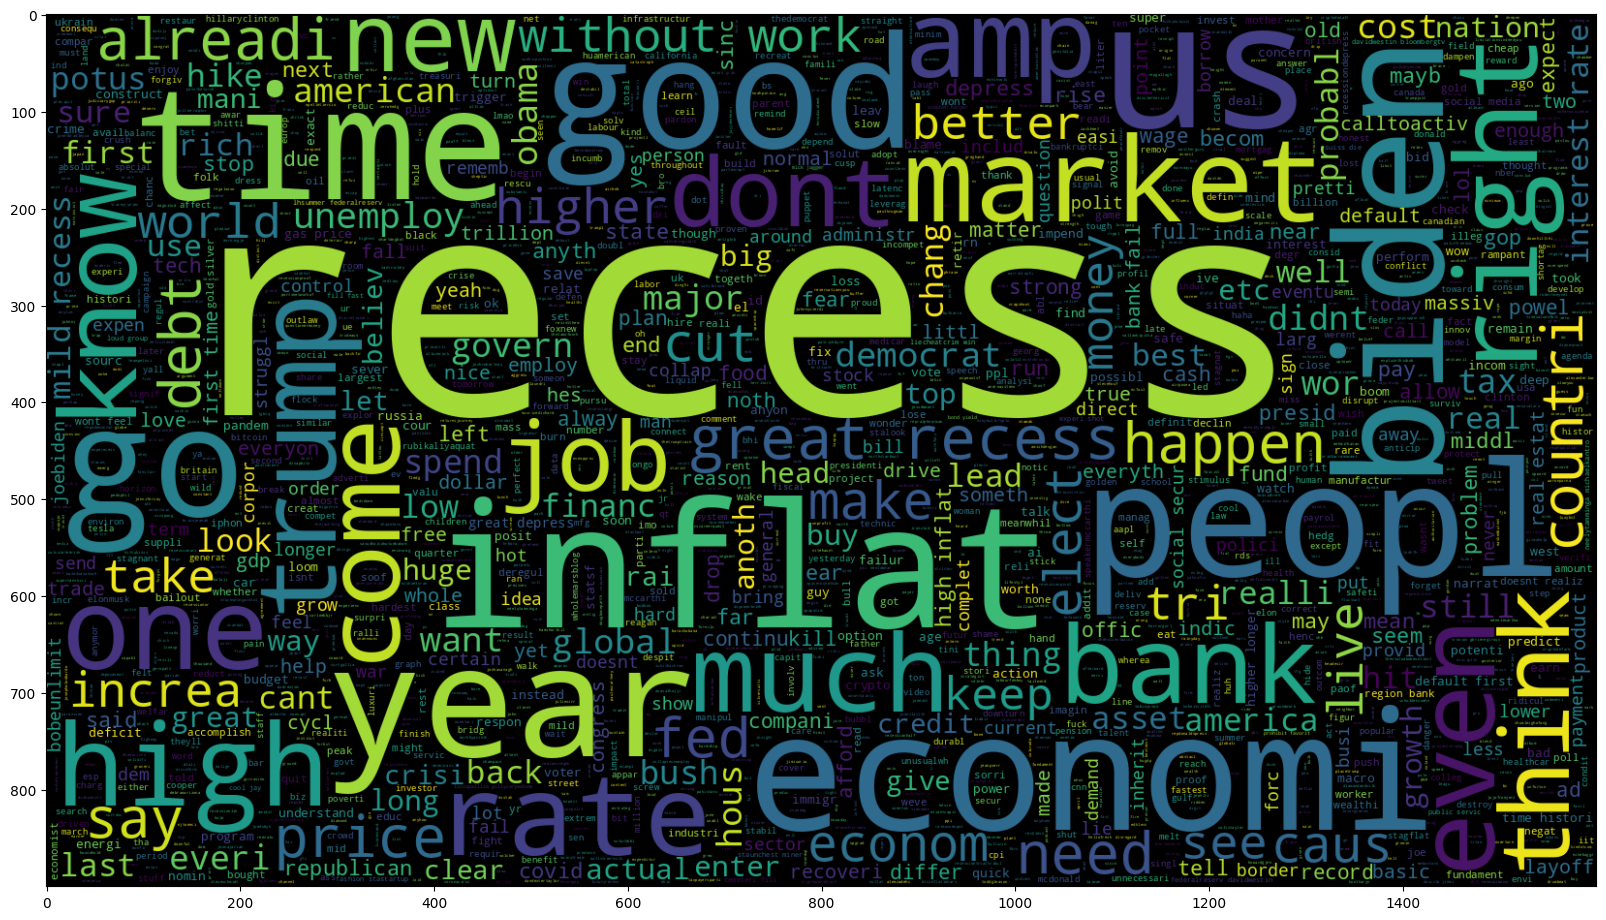

In [29]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_clean))
plt.imshow(wc , interpolation = 'bilinear')

#### Negative Sentiments Word Cloud

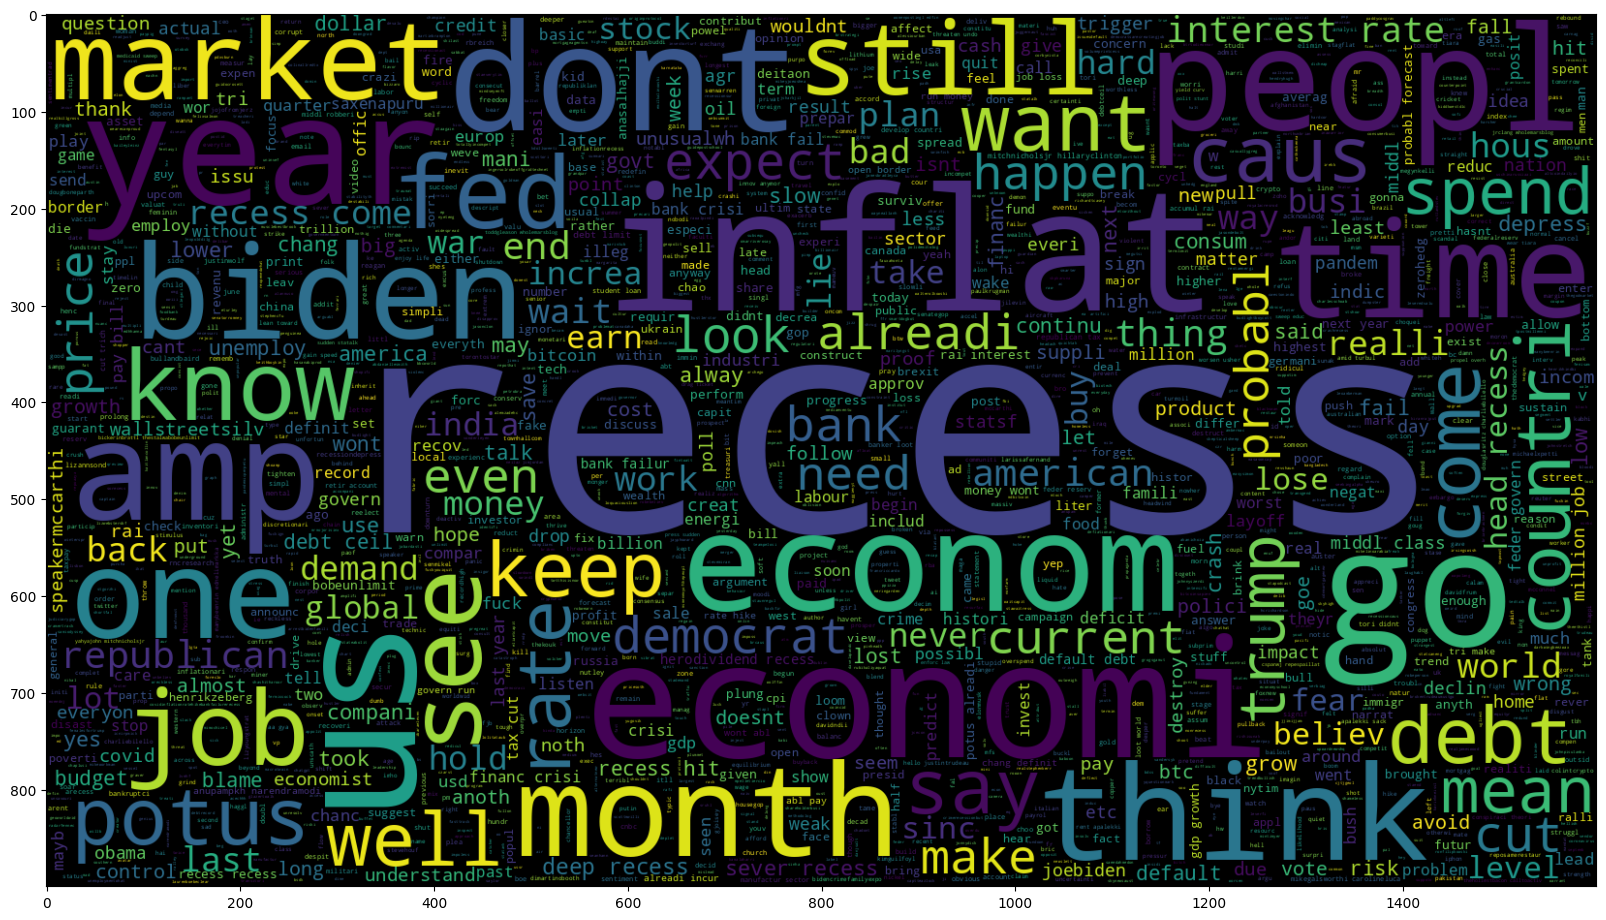

In [30]:
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_clean))
plt.imshow(wc , interpolation = 'bilinear')

## Training the Model

In [31]:
drop_cols= ("Date","Tweet")
preprocdatas = df.drop(*drop_cols)

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression

# Definisi stages untuk pipeline
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words_tokens")
countVectorizer = CountVectorizer(inputCol="words_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
logisticRegression = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 10)

# Membuat pipeline dengan stages
pipeline = Pipeline(stages=[tokenizer, countVectorizer, idf, logisticRegression])

# Split data menjadi train set dan test set
seed = 42  # set seed for reproducibility
trainDF, testDF = preprocdatas.randomSplit([0.7, 0.3], seed)

# Melatih model dengan data train menggunakan pipeline
model = pipeline.fit(trainDF)


In [33]:
predictions = model.transform(testDF)

In [34]:
pred = predictions.toPandas()
pred.head()

,text_clean,label,words_tokens,rawFeatures,features,rawPrediction,probability,prediction
0,,0,[],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.861769995862287, -5.861769995862287]","[0.9971618764146486, 0.002838123585351404]",0.0
1,,0,[],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.861769995862287, -5.861769995862287]","[0.9971618764146486, 0.002838123585351404]",0.0
2,alreadi seen mani pune especi local builder s...,0,"[, alreadi, seen, mani, pune, especi, local, b...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.3497545010941586, 1.2361198296722717, 0.0, ...","[2.305795152101517, -2.305795152101517]","[0.9093558550758548, 0.09064414492414519]",0.0
3,anupampkh narendramodi plea studi basic econo...,0,"[, anupampkh, narendramodi, plea, studi, basic...","(2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.6995090021883172, 1.2361198296722717, 0.0, ...","[-1.1569202397994092, 1.1569202397994092]","[0.23922734395393663, 0.7607726560460634]",1.0
4,economi danger,0,"[, economi, danger]","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.2361198296722717, 0.0, 0.0, 0.0, 2.701...","[3.0245654257513306, -3.0245654257513306]","[0.9536716535636671, 0.04632834643633288]",0.0


## Detail pipelines for model building step by step

### Tokenizing the Text

In [35]:
words_tokens = tokenizer.transform(preprocdatas)
words_tokens.show()

+--------------------+-----+--------------------+
|          text_clean|label|        words_tokens|
+--------------------+-----+--------------------+
| us full news deb...|    1|[, us, full, news...|
|saxenapuru know c...|    0|[saxenapuru, know...|
|swimfish statsf s...|    0|[swimfish, statsf...|
|taxpayersparti av...|    1|[taxpayersparti, ...|
|lose happi index ...|    0|[lose, happi, ind...|
|                    |    0|                  []|
|thekouk decid rec...|    0|[thekouk, decid, ...|
|republican posit ...|    0|[republican, posi...|
|    kill million job|    0|[, kill, million,...|
|treasuri dept war...|    0|[treasuri, dept, ...|
| job amp caus rec...|    1|[, job, amp, caus...|
|cwestonindo drive...|    0|[cwestonindo, dri...|
|acechhh traumat r...|    0|[acechhh, traumat...|
|uber investor go ...|    0|[uber, investor, ...|
|suppli demand alw...|    0|[suppli, demand, ...|
|                    |    0|                  []|
|reserv bank conti...|    1|[reserv, bank, co...|


### Applying CountVectorizer

In [36]:
modls = countVectorizer.fit(words_tokens)
featurizedData = modls.transform(words_tokens)
featurizedData.show()

+--------------------+-----+--------------------+--------------------+
|          text_clean|label|        words_tokens|         rawFeatures|
+--------------------+-----+--------------------+--------------------+
| us full news deb...|    1|[, us, full, news...|(3959,[0,1,3,11,1...|
|saxenapuru know c...|    0|[saxenapuru, know...|(3959,[0,21,25,83...|
|swimfish statsf s...|    0|[swimfish, statsf...|(3959,[0,7,28,46,...|
|taxpayersparti av...|    1|[taxpayersparti, ...|(3959,[0,179,215,...|
|lose happi index ...|    0|[lose, happi, ind...|(3959,[119,121,15...|
|                    |    0|                  []|        (3959,[],[])|
|thekouk decid rec...|    0|[thekouk, decid, ...|(3959,[0,2,8,20,9...|
|republican posit ...|    0|[republican, posi...|(3959,[14,69,286]...|
|    kill million job|    0|[, kill, million,...|(3959,[1,17,163,3...|
|treasuri dept war...|    0|[treasuri, dept, ...|(3959,[76,113,302...|
| job amp caus rec...|    1|[, job, amp, caus...|(3959,[0,1,6,15,1...|
|cwest

### Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [37]:
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|          text_clean|label|        words_tokens|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
| us full news deb...|    1|[, us, full, news...|(3959,[0,1,3,11,1...|(3959,[0,1,3,11,1...|
|saxenapuru know c...|    0|[saxenapuru, know...|(3959,[0,21,25,83...|(3959,[0,21,25,83...|
|swimfish statsf s...|    0|[swimfish, statsf...|(3959,[0,7,28,46,...|(3959,[0,7,28,46,...|
|taxpayersparti av...|    1|[taxpayersparti, ...|(3959,[0,179,215,...|(3959,[0,179,215,...|
|lose happi index ...|    0|[lose, happi, ind...|(3959,[119,121,15...|(3959,[119,121,15...|
|                    |    0|                  []|        (3959,[],[])|        (3959,[],[])|
|thekouk decid rec...|    0|[thekouk, decid, ...|(3959,[0,2,8,20,9...|(3959,[0,2,8,20,9...|
|republican posit ...|    0|[republican, posi...|(3959,[14,69,286]...|(3959,[14,

#### Detailed Split Data

In [38]:
trainDF.count()

863

In [39]:
trainDF.show()

+--------------------+-----+
|          text_clean|label|
+--------------------+-----+
|                    |    0|
|                    |    0|
|                    |    0|
|                    |    0|
|                    |    0|
|                    |    0|
| asyounotwish one...|    1|
| chanc countri mi...|    0|
| deterior financ ...|    1|
| give tax cut wea...|    0|
|       global unrest|    0|
|                 goe|    0|
| help retir milli...|    0|
| india remain uns...|    0|
| kobeissilett pre...|    1|
| move inflat inco...|    0|
| one staunchest m...|    1|
| rich actual make...|    1|
| statsf global re...|    0|
|                wait|    0|
+--------------------+-----+
only showing top 20 rows



In [40]:
trainDF.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  243|
|    0|  620|
+-----+-----+



## Evaluating the Model

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [42]:
evaluator = BinaryClassificationEvaluator(labelCol = "label", metricName='areaUnderROC')

In [43]:
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of our Logistic Regression model is: 0.8219194002963651


### Classification Report and Confusion Matrix

In [44]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [45]:
y_true.value_counts()

0.0    271
1.0    127
Name: label, dtype: int64

In [46]:
y_pred.value_counts()

0.0    278
1.0    120
Name: prediction, dtype: int64

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       271
         1.0       0.64      0.61      0.62       127

    accuracy                           0.77       398
   macro avg       0.73      0.72      0.73       398
weighted avg       0.76      0.77      0.76       398



<Axes: >

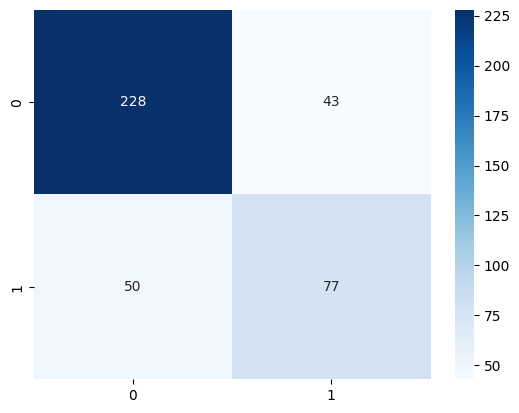

In [48]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')